# Using `astropy.io.fits` and `astropy.wcs` to load and manipulate FITS images

In this tutorial, we will learn how to use `astropy.io.fits` to load/save FITS images and tables. We will also use `astropy.wcs` in conjuction with a FITS header in order to map between world and pixel coordinates.

In [1]:
from __future__ import print_function, division # making syntax more like python3 to give future me less of a headache

from astropy.io import fits
from astropy.wcs import WCS
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

C:\Users\PaulHancock\Anaconda2\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The fits file that we are interested in needs to be downloaded so we need to load the following.

In [2]:
from astropy.utils.data import download_file

## Loading and working with fits images

In [ ]:
# load an image from the astropy demos
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

The above `cache=True` means that the data is loaded directly into this notebook. We want to save the file to disk, so we use the `.save()` function. Note that for `astropy <= 1.3` you must use the `clobber` keyword to overwrite a file.

In [ ]:
image_file.save('HorseHead.fits', overwrite=True)
del image_file # lets pretend that the file was on disk the whole time

Loading a FITS file is easy, and there are multiple ways to do it. The first method is to just do `fits.open()` which will load the file into an `hdu_list` object which contains the header, and the data, for all extensions. When the file is opened the header will be read, however the data is not read until the first time that you look at or touch the data element.
Alternatively you can load just the header by using `fits.getheader()` and you can load just the data (as an `np.array`) using `fits.getdata()`. For now we load both at once.

In [3]:
#hdu_list = fits.open('HorseHead.fits')
hdu_list = fits.open('1904-66_SIN.fits')
header = hdu_list[0].header
data = hdu_list[0].data
hdu_list.info()

Filename: 1904-66_SIN.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     117   (192, 192)   float32   


The fits header is loaded as a dictionary of `KEYWORD=VALUE` pairs. All of the HISTORY elements are concatenated into a single long string that is accessed via `header['HISTORY']`, and will be appended to when you do something like `header['HISTORY'] = 'more infos'`

### Exercise:
Determine the projection that is used in our fits file by looking for the `CTYPE1` and `CTYPE2` keys in the fits header.

In [ ]:
# 

And now determine the data type and size of the image by looking at the data element. Confirm that this data is as reported by the fits header.

In [ ]:
# 

## Viewing the image data and getting basic statistics

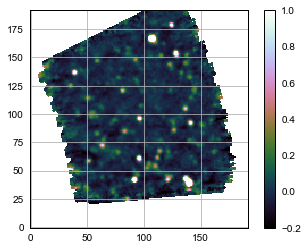

In [49]:
plt.imshow(data, cmap='cubehelix', vmin=-0.2, vmax = 1, origin = 'lower')
plt.colorbar()

Let's get some basic stats for the image

In [10]:
print('Min:', np.min(data))
print('Max:', np.max(data))
print('Mean:', np.mean(data))
print('Stdev:', np.std(data))

Min: nan
Max: nan
Mean: nan
Stdev: nan


Looking at the image that we made we see that there are plenty of data points outside of the area of interest, that are represented by `np.nan` values. Thus all the min/max/mean/std functions just show `np.nan` as a result.

Pixels in an images that are not measured or mapped should be represented as a blank value. The FITS header allows you to map whatever you like to blank by using the BLANK keyword. `astropy.io.fits` will then convert these blank values to `np.nan`. So long as you use functions like `np.nanmin` to calculate stats on the image you will not be using data from the blanked regions. Some people/programs like to fill the blank values with zeros. THIS IS WRONG AND SHOULD NEVER BE DONE.

Copy/paste the above cell, and use `np.nanmin` etc.. instead.

### Plotting a histogram

To make a histogram with `matplotlib.pyplot.hist()`, I need to cast the data from a 2-D to array to something one dimensional.

In this case, I am using the iterable python object `data.flat`.

In [12]:
print(type(data.flat))

<type 'numpy.flatiter'>


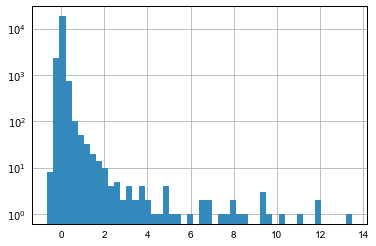

In [27]:
mask = np.where(np.isfinite(data)) # Select all the data that is finite (not nan or +/- inf)
histogram = plt.hist(data[mask].flat, log=True, bins=50)

I won't go into too much detail about showing images here, since interactive viewers like ds9 are better for exploring data, and purpose made modules like `aplpy` are better for making your publication images. See the astropy FITS-images tutorial, on which this is based, for some futher examples of showing images with different stretches and scales.

### Using WCS from the FITS header to map between pixel and sky (world) coordinates

The FITS header contains all the information that a viewer like ds9 will need to map (x,y) pixel coordinates onto world coordinates (ra,dec), (l,b) or w/e system is defined.

We can thus use the FITS header to create a new WCS object that will allow us access to these coordinate conversions.

In [32]:
wcs = WCS(header)
print(wcs.axis_type_names)

[u'RA', u'DEC']


The functions `all_world2pix()` and `all_pix2world()` are what we want. They take a 2d array of coordinates, and an origin as arguments. Using `WCS.all_world2pix?` for details. The origin is either 1 or 0, and you'll get it wrong many times over. Also note that python uses indices that are fast-> slow meaning that you index an images as `[y][x]`.

In [37]:
ypix, xpix = 100, 250
radec = wcs.all_pix2world([ [ypix, xpix]], 0)
print("RA, DEC is: {0}".format(radec))

yx = wcs.all_world2pix(radec, 0)
print("Y, X is: {0}".format(yx))

RA, DEC is: [[ 305.73323537  -61.00325497]]
Y, X is: [[ 100.  250.]]


### Exercise:
What happens if we request the coordinates of a position that is outside the image?
Try with x,y being negative also!

In [41]:
# 

For some projections you will always get a sensible answer, but not all projections are able to uniquely map ra,dec -> x,y for the entire sky.

The WCS is just a coordinate transform and is thus able to be defined outside of the region represented by the data. This means that the `CRVAL{1,2}` and `CRPIX{1,2}` parameters, which represent the reference positions, need not be within the image! This is actually quite nice.

### Modifying the WCS

We can change the WCS by editing the parameters in the FITS header before loading the `WCS` object. If we change the shape of the data by cropping, or modifying dimensions (e.g. dropping empty dimensions), then when we save back to a FITS file astropy will automagically update the `NAXIS` and related header elements to reflect this.

First we determine the reference pixels. Note that even though we index the header as if it were a dictionary, `astropy` does some magic behind the scenes meaning that we can use wild cards in the indexes like this:

In [47]:
header['CR*']

CRPIX1  =  -2.371895431541E+02                                                  
CRVAL1  =   0.000000000000E+00                                                  
CRPIX2  =   7.688571124876E+00                                                  
CRVAL2  =  -9.000000000000E+01                                                  

The above is telling us that the south pole (0, -90) is at pixel coords of about (-2371, 7.68).

Lets trim our image so that there are no blank pixels. We can do this by selecting just the inner 50x150 pixels.

In [48]:
trimmed = data[50:151,50:151]

Now we can save the image by overwriting the data with this trimmed data. But before we do we need to update the fits header to that what is now pixel (0,0) has the same coordinates as the old pixel (50,50). Since the new region is smaller than the old region we just need to modify the CRPIX{1,2} values to include this shift.

### Exercise
Update the fits header by modifying the CRPIX1 and CRPIX2 values.

In [ ]:
#

Now replace the image data with the trimmed data and save to disk as '1904-66_SIN_trimmed.fits'

You can call the `.write()` function on an `HDUList` object to save it to disk.

In [ ]:
#

Now look at the header of the object you just saved... What has `astropy` automatically done for you?

In [ ]:
# 